# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook
- https://neptune.ai/blog/keras-metrics - good guide on creating custom metric in Keras
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [x] Submition Error When calculating results.
- [x] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [x] Solved problem with NaNs in metric -> min/max vals less than 1 more than 0, as in competrion calculator
- [ ] Research wheather it is possoble to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [ ] Ensemble Results by some model.

In [3]:
SUBMITION = False

## Install TabPFN offline

In [4]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [5]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [6]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Load the Dataset

In [7]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [8]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(
    columns=[i for i in dataset_df.columns if i not in ["Id","Class"]],         
    df=dataset_df)

  0%|          | 0/56 [00:00<?, ?it/s]

* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [9]:
def preprocess(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    woes = dict()
    numeric_features = stats[stats.logloss.notna()].index.tolist() # Cause for EJ logloss is null
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train_out[i], y=train_out['Class'])
        train_out[i + '_WoE'] = tmp_woe.transform(X=train_out[i])
        test_out[i + '_WoE'] = tmp_woe.transform(X=test_out[i])
        out_features.append(i + '_WoE')
        woes[i] = tmp_woe
    
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features, woes


train_out,test_out,features, woes = preprocess(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

In [10]:
basic_stats_2 = compute_basic_stats(
    columns=[i for i in train_out.columns if i not in ["Id","Class"]],         
    df=train_out)

basic_stats_2

  0%|          | 0/121 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU_WoE,4,0.0,float64,-0.52,-2.678782,2.977892,1.042059,0.286027,4.790242
FL_WoE,4,0.0,float64,-0.42,-2.045013,2.977892,0.86161,0.214552,5.374418
DI_WoE,3,0.0,float64,-0.37,-2.361247,0.382521,0.698812,0.124925,5.432836
DA_WoE,3,0.0,float64,-0.37,-2.093932,0.463416,0.719046,0.14452,5.549671
GL_WoE,4,0.0,float64,-0.4,-1.805209,2.977892,0.865805,0.230269,5.783341
FD_WoE,3,0.0,float64,-0.33,-1.996604,0.379845,0.635814,0.115675,5.783341
EH_WoE,3,0.0,float64,-0.32,-2.061142,0.343225,0.622624,0.111704,5.841759
EH,127,0.0,float64,0.18,-0.1635,22.876681,1.0,-0.0,5.900177
AM,605,0.0,float64,0.24,-0.513293,8.483647,1.0,0.0,5.900177
BC_WoE,3,0.0,float64,-0.3,-1.9811,0.486565,0.630381,0.116679,5.900177


# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [37]:
def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

def train_model(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6,
                model_obj = tfdf.keras.RandomForestModel,
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, dict,  dict):

    # Create a dataframe of required size with zero values.
    out_of_fold = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition = pd.DataFrame(data=np.zeros((len(test.index),n_splits)),index=test.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    # Names of columns
    submition_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]
            
            print('Sum of 1"s :',train_df[label].sum())
            print('Sum of 1"s :',valid_df[label].sum())

            # We need to convert the datatset from Pandas format (pd.DataFrame)
            # into TensorFlow Datasets format (tf.data.Dataset).
            train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define & Train the model and metrics
            model = model_obj(**model_kwargs)
            model.compile(**model_compile_kwargs) 
            model.fit(x=train_ds, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in out_of_fold dataframe
            out_of_fold.loc[valid_ids, 0] = model.predict(x=valid_ds).flatten()
            submition[i] = model.predict(x=submition_ds).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=train_ds,return_dict=True)
            train_metric = evaluation["balanced_log_loss"]
            
            evaluation = model.evaluate(x=valid_ds,return_dict=True)
            val_metric = evaluation["balanced_log_loss"]
            
            # Plot Results
            plot_train_logs(model)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
         
    
            
    return submition,models,metrics

class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_true = tf.math.minimum(y_true, [max_val])
        y_true = tf.math.maximum(y_true, [min_val])
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

# RandomForestModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpjwkpeisx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.918790. Found 555 examples.
Training model...
Model trained in 0:00:00.230070
Compiling model...


[INFO 23-07-21 05:07:56.6391 UTC kernel.cc:1242] Loading model from path /tmp/tmpjwkpeisx/model/ with prefix 617c75a3731442f0
[INFO 23-07-21 05:07:56.6796 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10190 node(s), and 112 input feature(s).
[INFO 23-07-21 05:07:56.6796 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 05:07:56.6797 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 362ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.3015


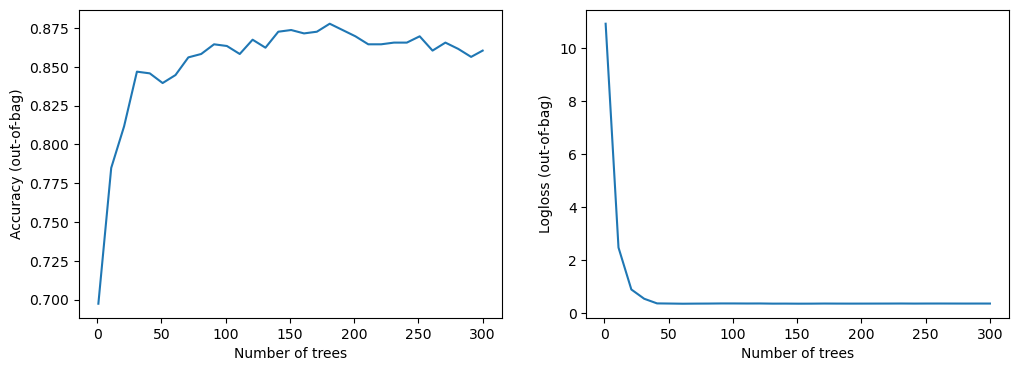


Train: 0.1855 Validation: 0.3015
##### Fold 2
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpveh3du4p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.013093. Found 555 examples.
Training model...
Model trained in 0:00:00.227987
Compiling model...


[INFO 23-07-21 05:08:03.1012 UTC kernel.cc:1242] Loading model from path /tmp/tmpveh3du4p/model/ with prefix 85d86dd8b0754665
[INFO 23-07-21 05:08:03.1424 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10330 node(s), and 113 input feature(s).
[INFO 23-07-21 05:08:03.1424 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 355ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3116


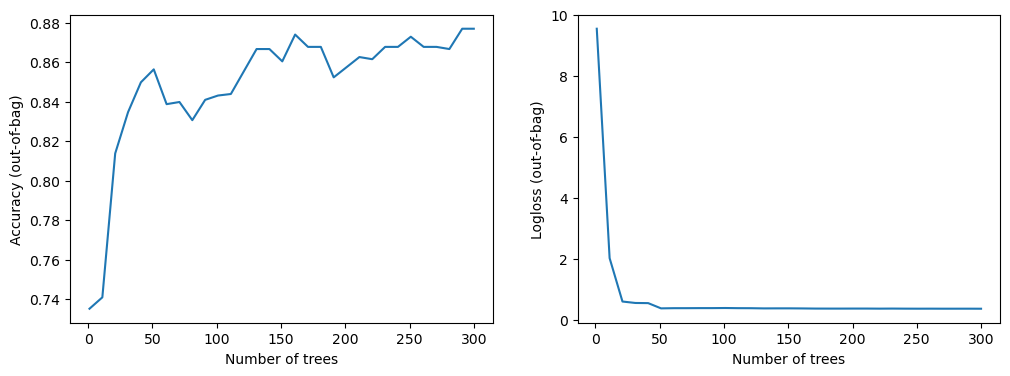


Train: 0.4840 Validation: 0.3116
##### Fold 3
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp5vhqf0p_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.957433. Found 555 examples.
Training model...
Model trained in 0:00:00.228137
Compiling model...


[INFO 23-07-21 05:08:09.3766 UTC kernel.cc:1242] Loading model from path /tmp/tmp5vhqf0p_/model/ with prefix 607b87ebfe354dfa
[INFO 23-07-21 05:08:09.4181 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10300 node(s), and 112 input feature(s).
[INFO 23-07-21 05:08:09.4181 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 05:08:09.4181 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 361ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8548 - balanced_log_loss: 0.4417


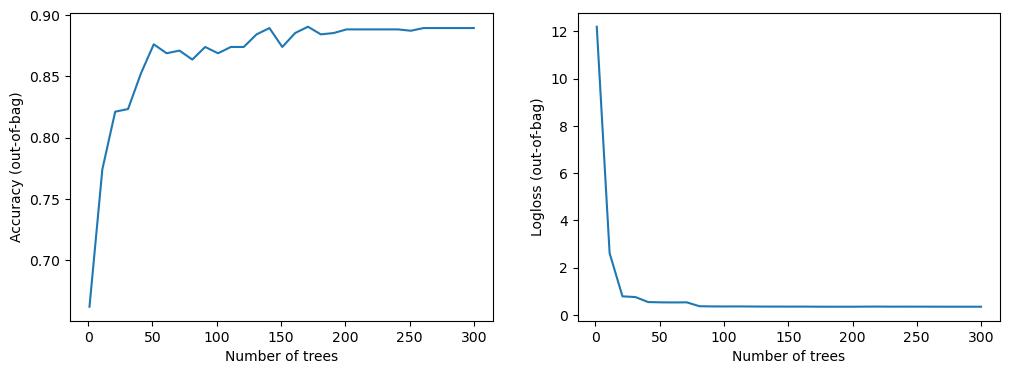


Train: 0.4848 Validation: 0.4417
##### Fold 4
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp6j6kh5mf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.933974. Found 555 examples.
Training model...
Model trained in 0:00:00.227344
Compiling model...


[INFO 23-07-21 05:08:16.8886 UTC kernel.cc:1242] Loading model from path /tmp/tmp6j6kh5mf/model/ with prefix 35727c5fd3694194
[INFO 23-07-21 05:08:16.9293 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10264 node(s), and 111 input feature(s).
[INFO 23-07-21 05:08:16.9294 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 359ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8710 - balanced_log_loss: 0.3305


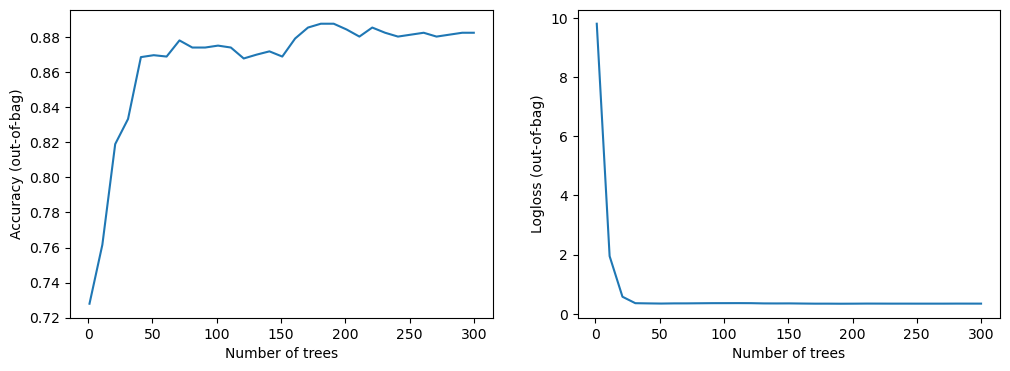


Train: 0.6168 Validation: 0.3305
##### Fold 5
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpcgbgfh_d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.919567. Found 555 examples.
Training model...
Model trained in 0:00:00.230454
Compiling model...


[INFO 23-07-21 05:08:24.3955 UTC kernel.cc:1242] Loading model from path /tmp/tmpcgbgfh_d/model/ with prefix b841e6a8dcae44c5
[INFO 23-07-21 05:08:24.4377 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10450 node(s), and 112 input feature(s).
[INFO 23-07-21 05:08:24.4378 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 05:08:24.4378 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 367ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3279


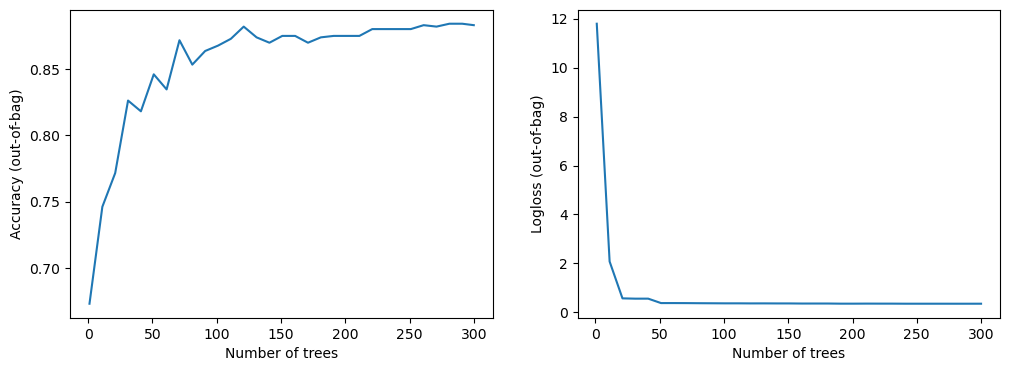


Train: 0.5066 Validation: 0.3279
##### Fold 6
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpw3jt0m1i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.938403. Found 555 examples.
Training model...
Model trained in 0:00:00.232171
Compiling model...


[INFO 23-07-21 05:08:31.2777 UTC kernel.cc:1242] Loading model from path /tmp/tmpw3jt0m1i/model/ with prefix bdfebad649e7436e
[INFO 23-07-21 05:08:31.3191 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10332 node(s), and 112 input feature(s).
[INFO 23-07-21 05:08:31.3191 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 371ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3564


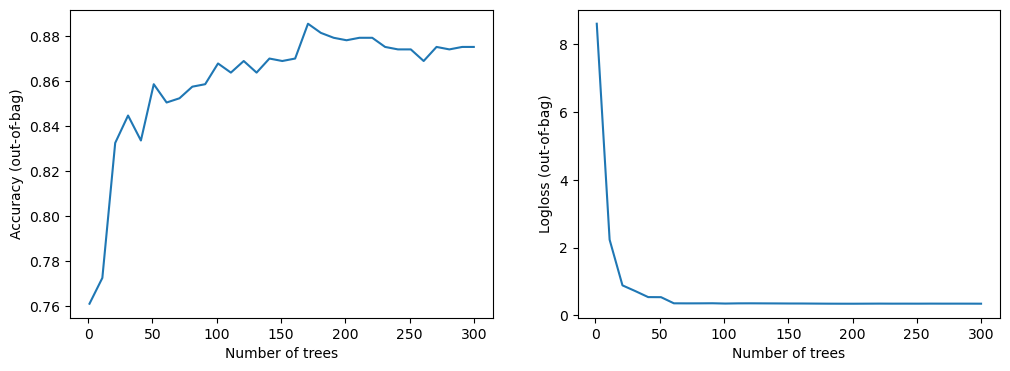


Train: 0.5020 Validation: 0.3564
##### Fold 7
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp8c9sguxa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.995313. Found 555 examples.
Training model...
Model trained in 0:00:00.229796
Compiling model...


[INFO 23-07-21 05:08:37.7880 UTC kernel.cc:1242] Loading model from path /tmp/tmp8c9sguxa/model/ with prefix f78553e5c0c14703
[INFO 23-07-21 05:08:37.8293 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10312 node(s), and 112 input feature(s).
[INFO 23-07-21 05:08:37.8294 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 05:08:37.8294 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 357ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.4016


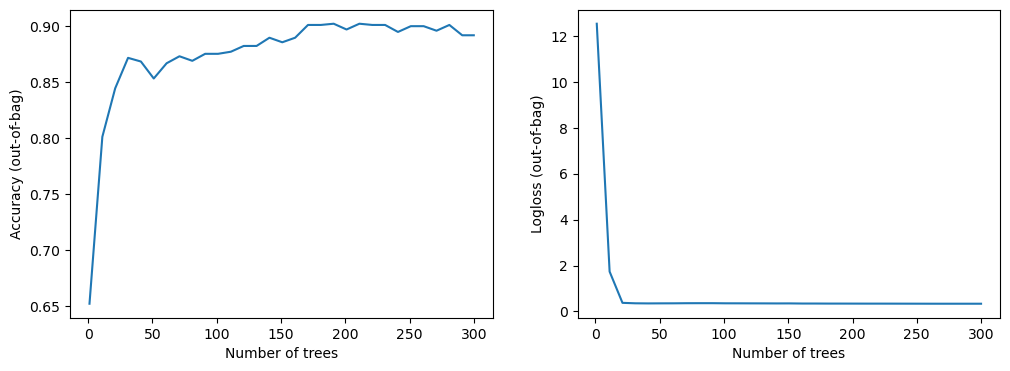


Train: 0.5269 Validation: 0.4016
##### Fold 8
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp6kxgm90m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.930069. Found 556 examples.
Training model...
Model trained in 0:00:00.232225
Compiling model...


[INFO 23-07-21 05:08:44.0659 UTC kernel.cc:1242] Loading model from path /tmp/tmp6kxgm90m/model/ with prefix 003e7a864cec45a1
[INFO 23-07-21 05:08:44.1085 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10334 node(s), and 112 input feature(s).
[INFO 23-07-21 05:08:44.1086 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 359ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.3344


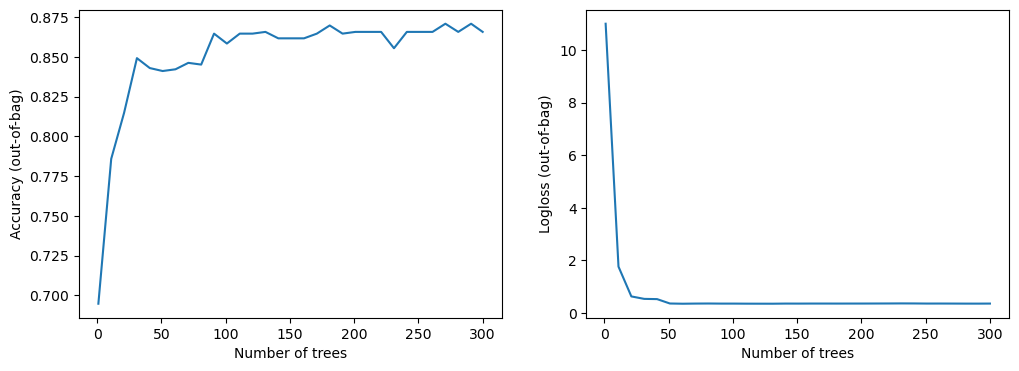


Train: 0.5754 Validation: 0.3344
##### Fold 9
Sum of 1"s : 98
Sum of 1"s : 10
Use /tmp/tmp3piyvxrx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.957079. Found 556 examples.
Training model...
Model trained in 0:00:00.238059
Compiling model...


[INFO 23-07-21 05:08:51.5655 UTC kernel.cc:1242] Loading model from path /tmp/tmp3piyvxrx/model/ with prefix 40976ddd041045a6
[INFO 23-07-21 05:08:51.6080 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10174 node(s), and 112 input feature(s).
[INFO 23-07-21 05:08:51.6080 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 05:08:51.6081 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 364ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.4160


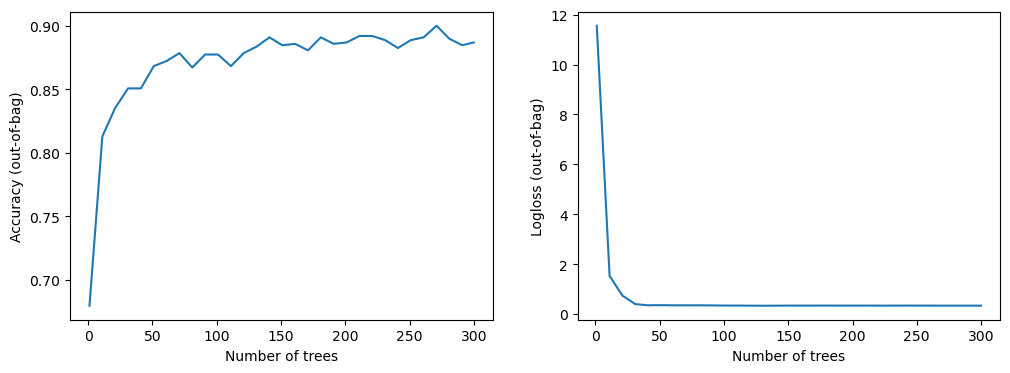


Train: 0.5072 Validation: 0.4160
##### Fold 10
Sum of 1"s : 98
Sum of 1"s : 10
Use /tmp/tmpvwcqrria as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.976763. Found 556 examples.
Training model...
Model trained in 0:00:00.230148
Compiling model...


[INFO 23-07-21 05:08:57.9145 UTC kernel.cc:1242] Loading model from path /tmp/tmpvwcqrria/model/ with prefix ba43918e7ad5452d
[INFO 23-07-21 05:08:57.9559 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10428 node(s), and 112 input feature(s).
[INFO 23-07-21 05:08:57.9560 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 361ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.2804


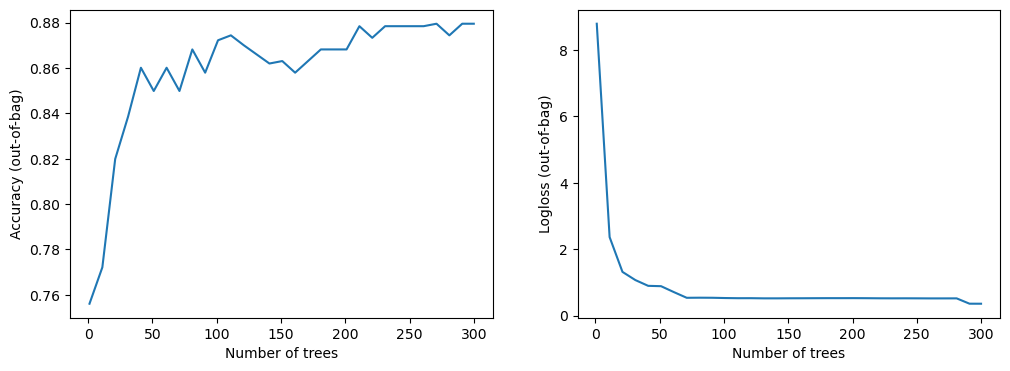


Train: 0.5957 Validation: 0.2804

Train mean: 0.4985 std: 0.1196

Validation mean: 0.3502 std: 0.0530


In [38]:
# RandomForestModel
if not SUBMITION:
    submition_rf_2, model_rf_2,metrics_rf_2 = train_model(
        train=train_out,test=test_out, features=features,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.RandomForestModel,           
        model_kwargs=dict(max_depth=6, num_trees=300),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp07s5m0p5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.149039. Found 555 examples.
Training model...
Model trained in 0:00:00.179721
Compiling model...


[INFO 23-07-21 05:09:20.2830 UTC kernel.cc:1242] Loading model from path /tmp/tmp07s5m0p5/model/ with prefix 3bfe733858fb4cf4
[INFO 23-07-21 05:09:20.3271 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11186 node(s), and 58 input feature(s).
[INFO 23-07-21 05:09:20.3273 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 05:09:20.3275 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 256ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2470


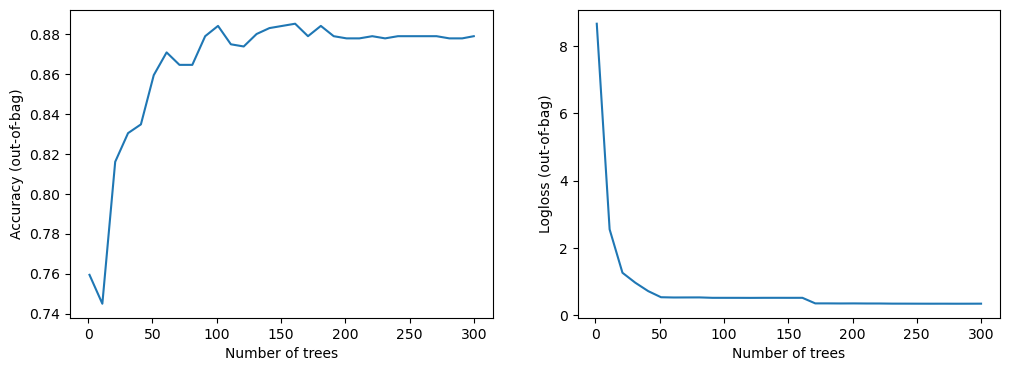


Train: 0.2012 Validation: 0.2470
##### Fold 2
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpqppavx2a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.144128. Found 555 examples.
Training model...
Model trained in 0:00:00.188730
Compiling model...


[INFO 23-07-21 05:09:24.4843 UTC kernel.cc:1242] Loading model from path /tmp/tmpqppavx2a/model/ with prefix 44450519e82b4d07
[INFO 23-07-21 05:09:24.5283 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-21 05:09:24.5284 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2757


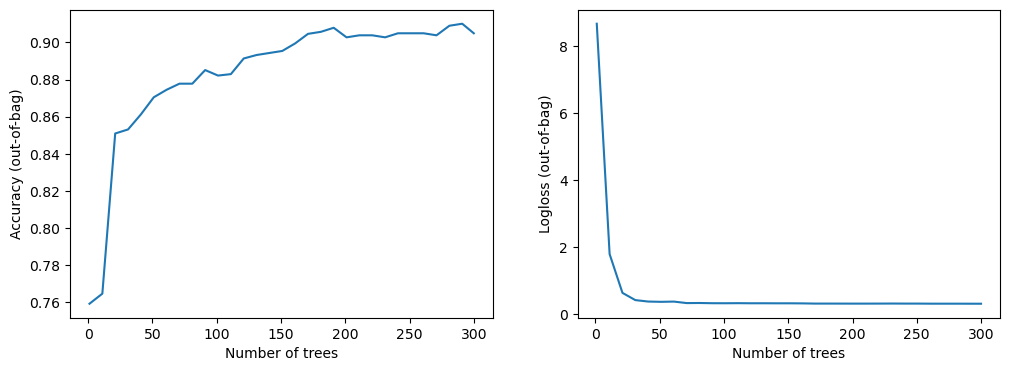


Train: 0.4433 Validation: 0.2757
##### Fold 3
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpjk7rssj8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.141370. Found 555 examples.
Training model...
Model trained in 0:00:00.177023
Compiling model...


[INFO 23-07-21 05:09:29.0414 UTC kernel.cc:1242] Loading model from path /tmp/tmpjk7rssj8/model/ with prefix 96d50e98025145a5
[INFO 23-07-21 05:09:29.0848 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11012 node(s), and 58 input feature(s).
[INFO 23-07-21 05:09:29.0849 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 312ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3758


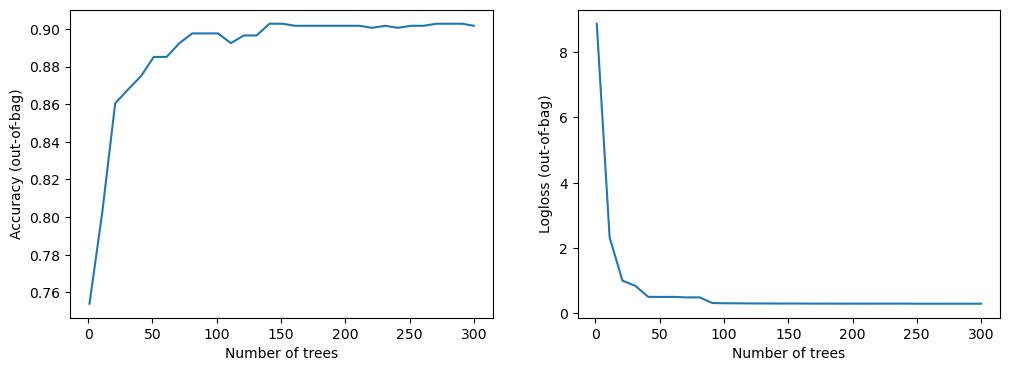


Train: 0.4615 Validation: 0.3758
##### Fold 4
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpk5i62_bz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.299668. Found 555 examples.
Training model...
Model trained in 0:00:00.223773
Compiling model...


[INFO 23-07-21 05:09:34.9600 UTC kernel.cc:1242] Loading model from path /tmp/tmpk5i62_bz/model/ with prefix 6c41f7eec09a4dc2
[INFO 23-07-21 05:09:35.0088 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-21 05:09:35.0089 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 05:09:35.0089 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3001


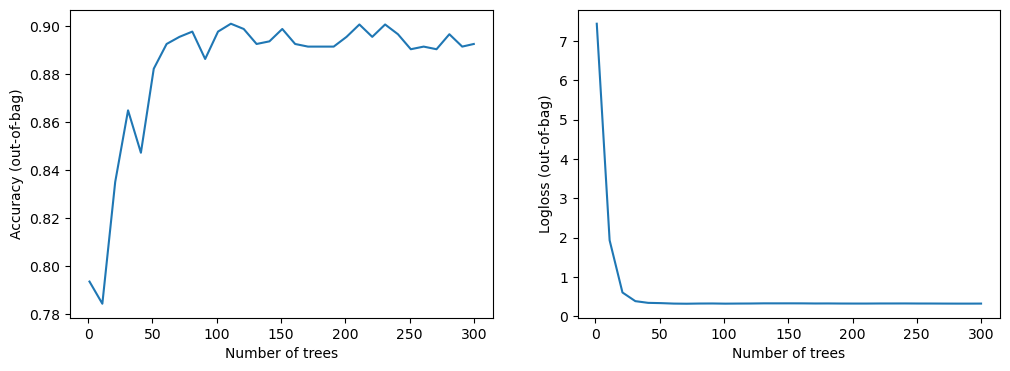


Train: 0.5660 Validation: 0.3001
##### Fold 5
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpxpqnds70 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.166993. Found 555 examples.
Training model...
Model trained in 0:00:00.180003
Compiling model...


[INFO 23-07-21 05:09:39.2136 UTC kernel.cc:1242] Loading model from path /tmp/tmpxpqnds70/model/ with prefix 0450944d58104346
[INFO 23-07-21 05:09:39.2586 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-21 05:09:39.2587 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2855


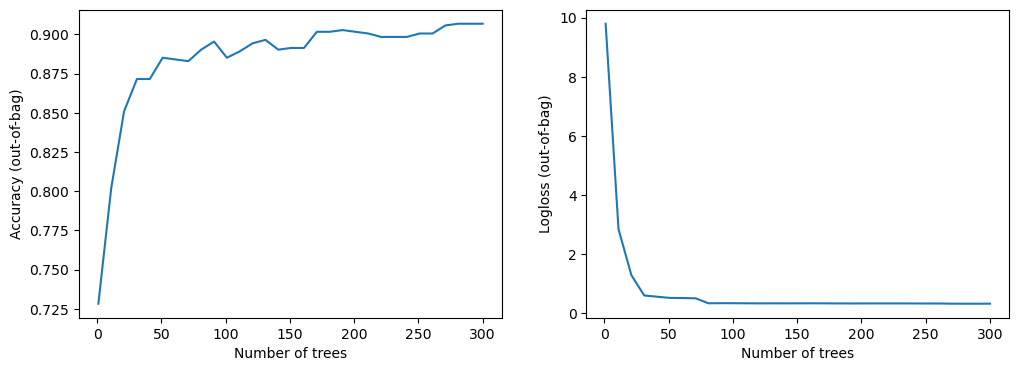


Train: 0.4859 Validation: 0.2855
##### Fold 6
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpu3iw8tvm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.150445. Found 555 examples.
Training model...
Model trained in 0:00:00.183359
Compiling model...


[INFO 23-07-21 05:09:43.4223 UTC kernel.cc:1242] Loading model from path /tmp/tmpu3iw8tvm/model/ with prefix 1e2297de00c94599
[INFO 23-07-21 05:09:43.4668 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11238 node(s), and 58 input feature(s).
[INFO 23-07-21 05:09:43.4668 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 271ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3069


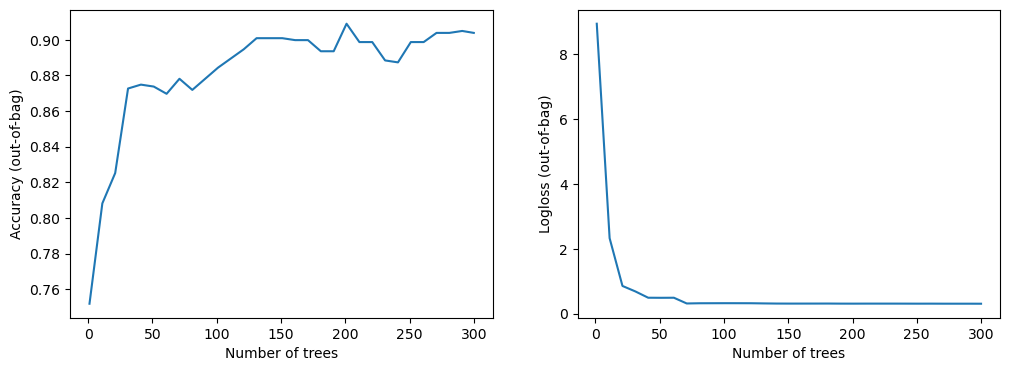


Train: 0.4704 Validation: 0.3069
##### Fold 7
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpi7dstrvi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.140854. Found 555 examples.
Training model...
Model trained in 0:00:00.180656
Compiling model...


[INFO 23-07-21 05:09:47.5703 UTC kernel.cc:1242] Loading model from path /tmp/tmpi7dstrvi/model/ with prefix 49eb96bd70ff4123
[INFO 23-07-21 05:09:47.6146 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11262 node(s), and 59 input feature(s).
[INFO 23-07-21 05:09:47.6146 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 05:09:47.6147 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3602


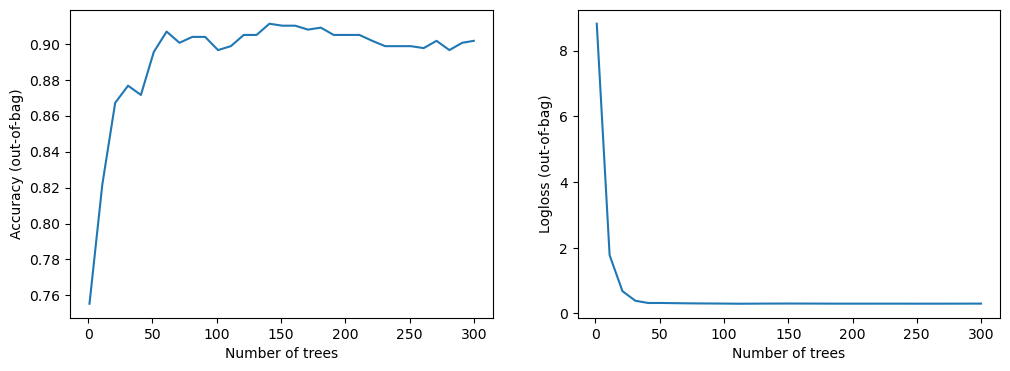


Train: 0.4883 Validation: 0.3602
##### Fold 8
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp0piiw763 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.165312. Found 556 examples.
Training model...
Model trained in 0:00:00.178900
Compiling model...


[INFO 23-07-21 05:09:51.6985 UTC kernel.cc:1242] Loading model from path /tmp/tmp0piiw763/model/ with prefix 92bf0a97316c42f5
[INFO 23-07-21 05:09:51.7424 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-21 05:09:51.7425 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.3318


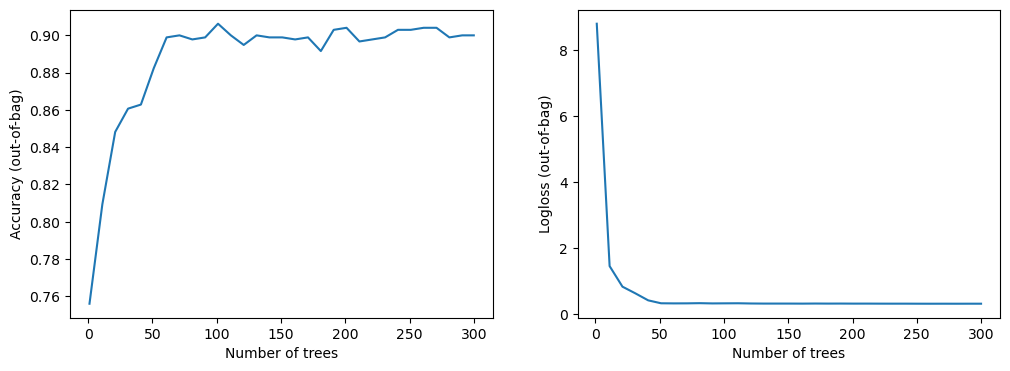


Train: 0.5488 Validation: 0.3318
##### Fold 9
Sum of 1"s : 98
Sum of 1"s : 10
Use /tmp/tmpn0fhhftv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.135115. Found 556 examples.
Training model...
Model trained in 0:00:00.185631
Compiling model...


[INFO 23-07-21 05:09:55.8765 UTC kernel.cc:1242] Loading model from path /tmp/tmpn0fhhftv/model/ with prefix 2f5bea9fa783400a
[INFO 23-07-21 05:09:55.9206 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11126 node(s), and 58 input feature(s).
[INFO 23-07-21 05:09:55.9207 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 256ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3449


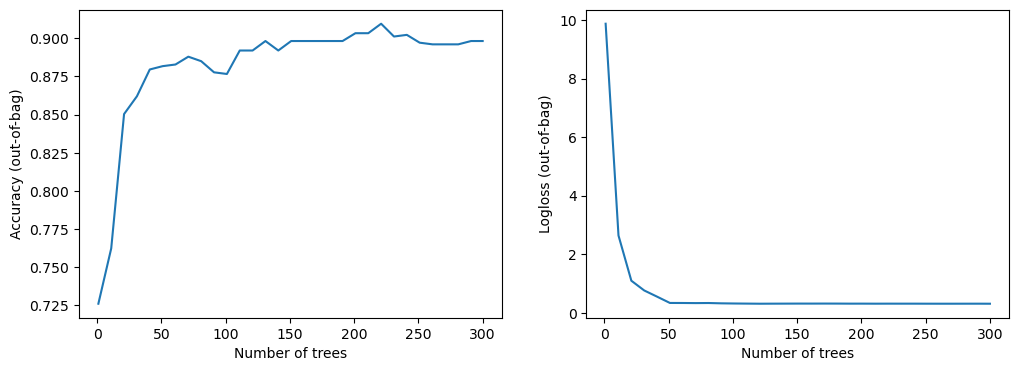


Train: 0.5168 Validation: 0.3449
##### Fold 10
Sum of 1"s : 98
Sum of 1"s : 10
Use /tmp/tmp0vfmbjnc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.155456. Found 556 examples.
Training model...
Model trained in 0:00:00.178285
Compiling model...


[INFO 23-07-21 05:10:00.0086 UTC kernel.cc:1242] Loading model from path /tmp/tmp0vfmbjnc/model/ with prefix c6f7b952ad7a49ba
[INFO 23-07-21 05:10:00.0521 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11154 node(s), and 58 input feature(s).
[INFO 23-07-21 05:10:00.0522 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-21 05:10:00.0522 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 256ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.2687


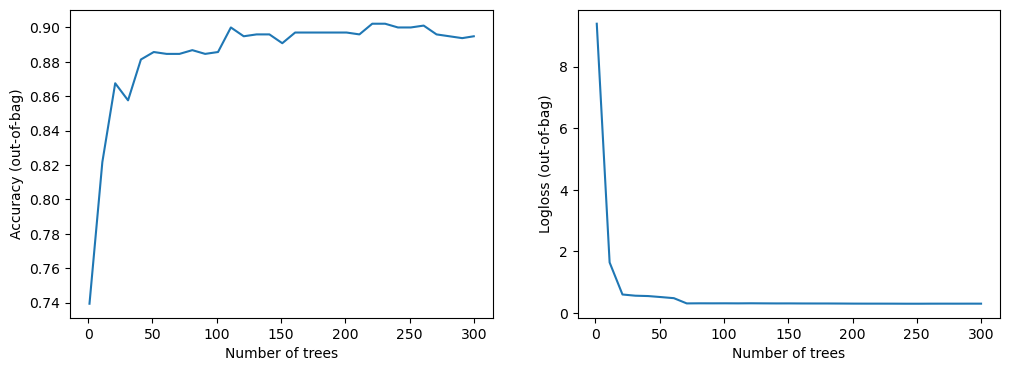


Train: 0.5330 Validation: 0.2687

Train mean: 0.4715 std: 0.1028

Validation mean: 0.3096 std: 0.0423


In [40]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

submition_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# GradientBoostedTreesModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpiy5dsf12 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:10:41.0549 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:10:41.0549 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:10:41.0549 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.177711. Found 555 examples.
Training model...
Model trained in 0:00:01.921625
Compiling model...


[INFO 23-07-21 05:10:44.1419 UTC kernel.cc:1242] Loading model from path /tmp/tmpiy5dsf12/model/ with prefix 91b4544e1fa04635
[INFO 23-07-21 05:10:44.1622 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 05:10:44.1624 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 255ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_log_loss: 0.0299


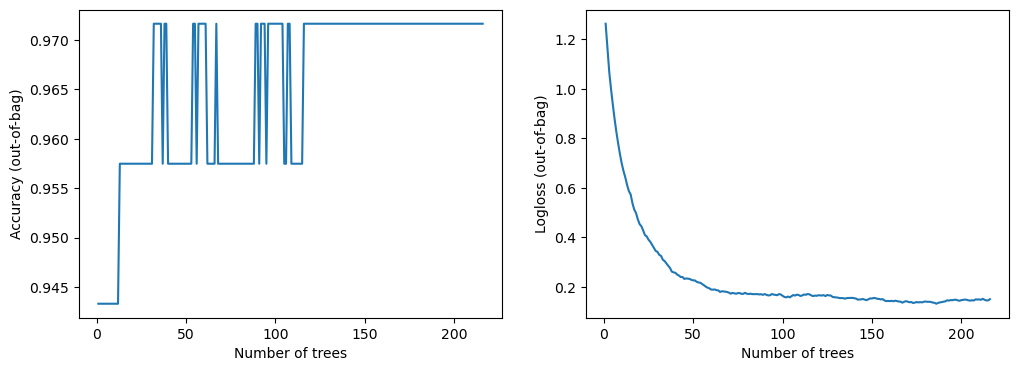


Train: 0.0060 Validation: 0.0299
##### Fold 2
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp8k4ga9or as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:10:49.4922 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:10:49.4923 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:10:49.4923 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.143588. Found 555 examples.
Training model...
Model trained in 0:00:01.805864
Compiling model...


[INFO 23-07-21 05:10:52.4305 UTC kernel.cc:1242] Loading model from path /tmp/tmp8k4ga9or/model/ with prefix 206705c953f04a62
[INFO 23-07-21 05:10:52.4490 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1438


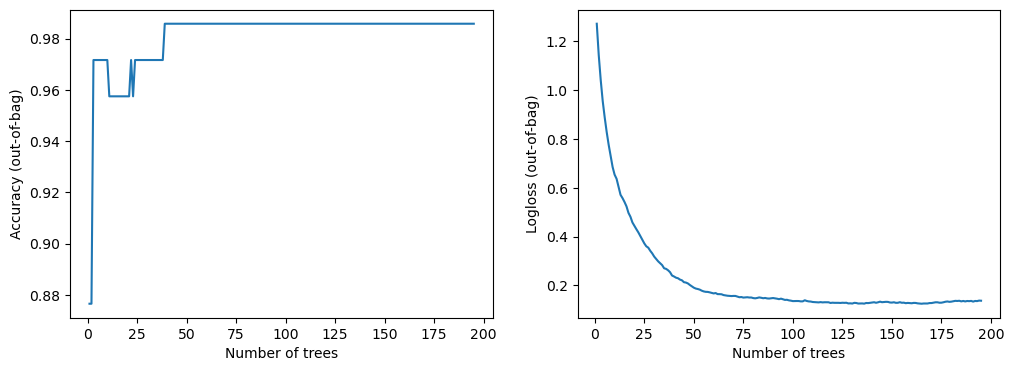


Train: 0.0360 Validation: 0.1438
##### Fold 3
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpigdyut6v as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:10:55.2723 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:10:55.2723 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:10:55.2724 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.160049. Found 555 examples.
Training model...
Model trained in 0:00:02.260853
Compiling model...


[INFO 23-07-21 05:10:58.6769 UTC kernel.cc:1242] Loading model from path /tmp/tmpigdyut6v/model/ with prefix a0dfe66370ad41a3
[INFO 23-07-21 05:10:58.7009 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 05:10:58.7009 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.8838


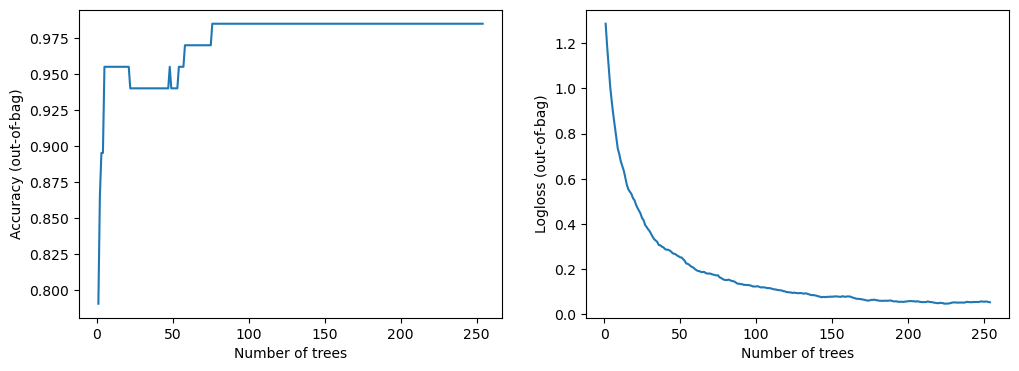


Train: 0.1457 Validation: 0.8838
##### Fold 4
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp80unw1_1 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:11:01.5414 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:01.5414 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:01.5414 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.179264. Found 555 examples.
Training model...
Model trained in 0:00:02.320722
Compiling model...


[INFO 23-07-21 05:11:05.0233 UTC kernel.cc:1242] Loading model from path /tmp/tmp80unw1_1/model/ with prefix 034841cd86f048a7
[INFO 23-07-21 05:11:05.0489 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.3553


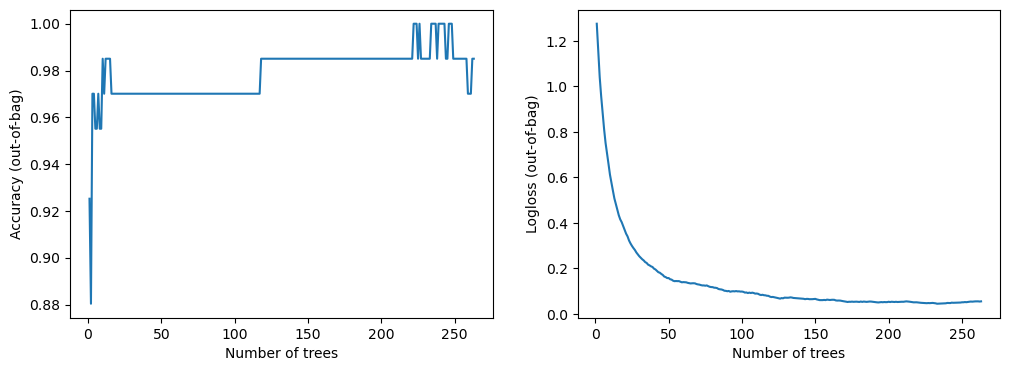


Train: 0.8856 Validation: 0.3553
##### Fold 5
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp40t4pmon as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:11:08.6710 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:08.6710 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:08.6711 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.195107. Found 555 examples.
Training model...
Model trained in 0:00:02.513467
Compiling model...


[INFO 23-07-21 05:11:12.3597 UTC kernel.cc:1242] Loading model from path /tmp/tmp40t4pmon/model/ with prefix 3600f3f2b7784fec
[INFO 23-07-21 05:11:12.3868 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 05:11:12.3868 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.5371


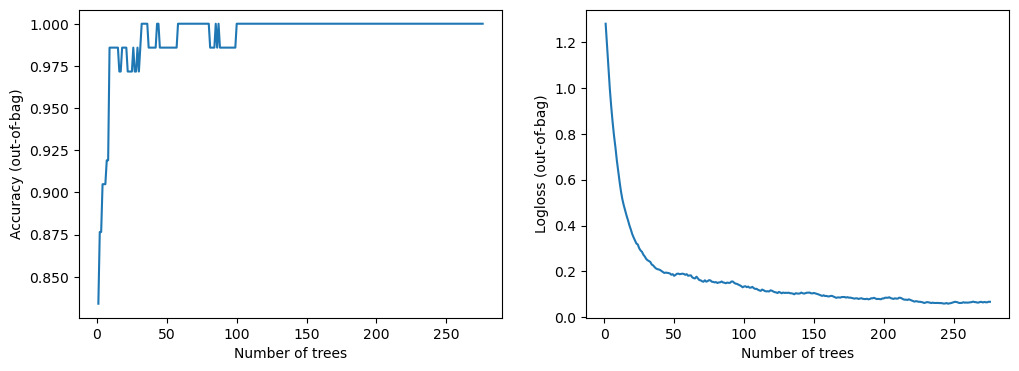


Train: 0.3576 Validation: 0.5371
##### Fold 6
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpgf746tbp as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:11:17.1271 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:17.1271 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:17.1271 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.155858. Found 555 examples.
Training model...
Model trained in 0:00:01.285527
Compiling model...


[INFO 23-07-21 05:11:19.5650 UTC kernel.cc:1242] Loading model from path /tmp/tmpgf746tbp/model/ with prefix fbdbf45a2f4f47ca
[INFO 23-07-21 05:11:19.5780 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2998


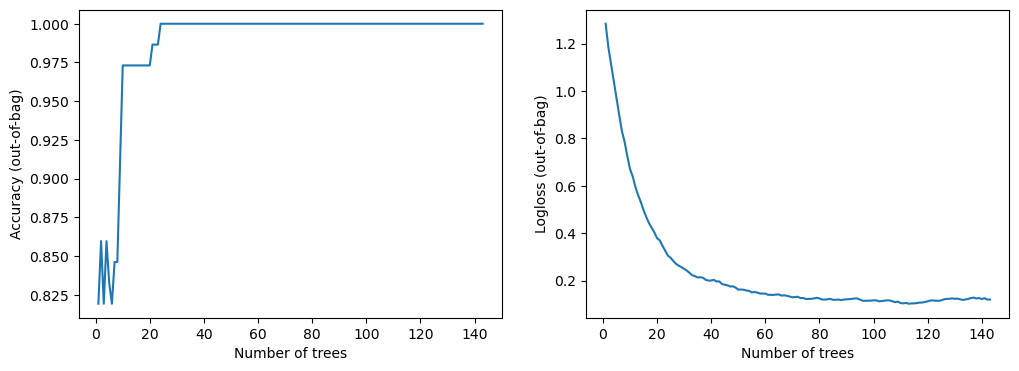


Train: 0.5467 Validation: 0.2998
##### Fold 7
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmps2yb4fwi as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:11:22.3911 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:22.3911 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:22.3911 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.166249. Found 555 examples.
Training model...
Model trained in 0:00:00.581470
Compiling model...


[INFO 23-07-21 05:11:24.1426 UTC kernel.cc:1242] Loading model from path /tmp/tmps2yb4fwi/model/ with prefix 6babcb8480bc4cc6
[INFO 23-07-21 05:11:24.1473 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 05:11:24.1474 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 255ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3052


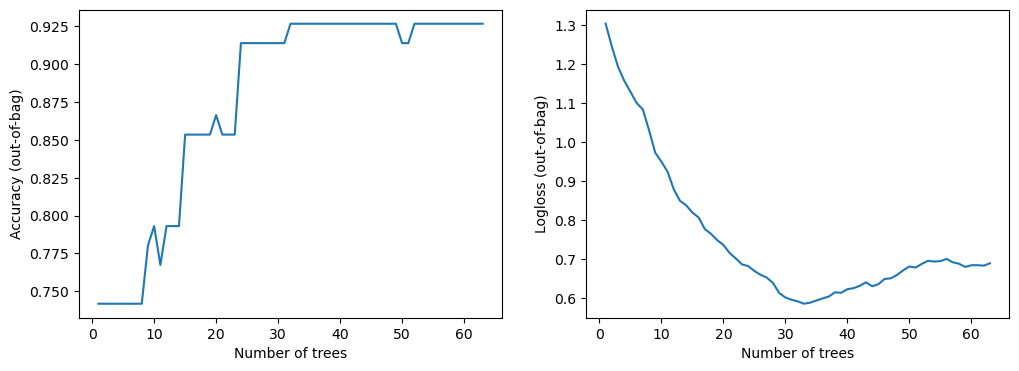


Train: 0.4053 Validation: 0.3052
##### Fold 8
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp4_ore5x7 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:11:26.8957 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:26.8957 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:26.8957 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.168323. Found 556 examples.
Training model...
Model trained in 0:00:00.597493
Compiling model...


[INFO 23-07-21 05:11:28.6659 UTC kernel.cc:1242] Loading model from path /tmp/tmp4_ore5x7/model/ with prefix 677bd545717f47fa
[INFO 23-07-21 05:11:28.6704 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3190


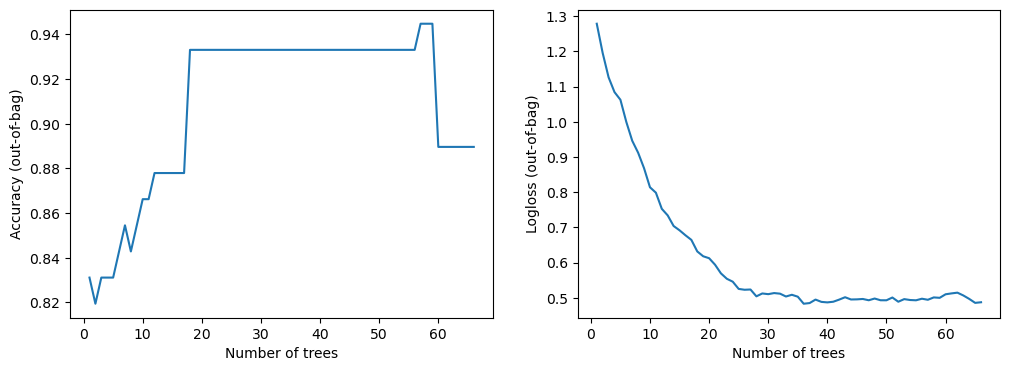


Train: 0.4007 Validation: 0.3190
##### Fold 9
Sum of 1"s : 98
Sum of 1"s : 10
Use /tmp/tmpbw9rw0ue as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:11:31.4638 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:31.4640 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:31.4642 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.183179. Found 556 examples.
Training model...
Model trained in 0:00:00.934828
Compiling model...


[INFO 23-07-21 05:11:33.5822 UTC kernel.cc:1242] Loading model from path /tmp/tmpbw9rw0ue/model/ with prefix 3c74ca789dfc4adb
[INFO 23-07-21 05:11:33.5905 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4456


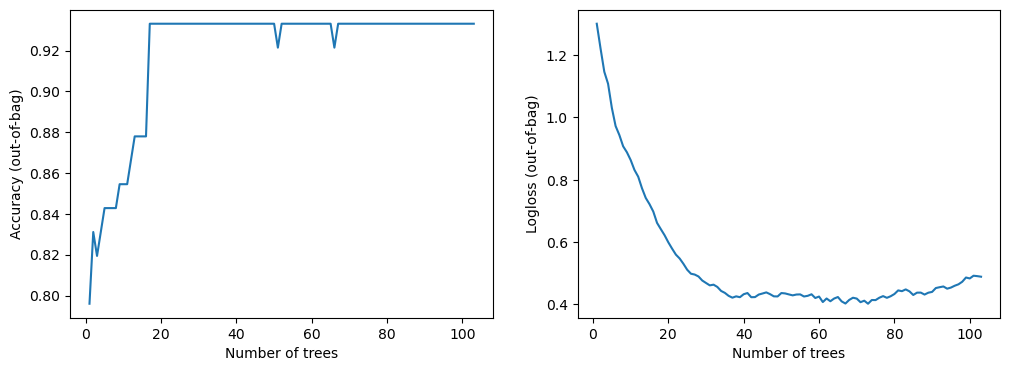


Train: 0.3539 Validation: 0.4456
##### Fold 10
Sum of 1"s : 98
Sum of 1"s : 10
Use /tmp/tmp7bpjbzke as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:11:37.2755 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:37.2755 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:11:37.2755 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.173349. Found 556 examples.
Training model...
Model trained in 0:00:00.670149
Compiling model...


[INFO 23-07-21 05:11:39.1225 UTC kernel.cc:1242] Loading model from path /tmp/tmp7bpjbzke/model/ with prefix 8ff11187bd3c45e0
[INFO 23-07-21 05:11:39.1270 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 05:11:39.1270 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_log_loss: 0.2912


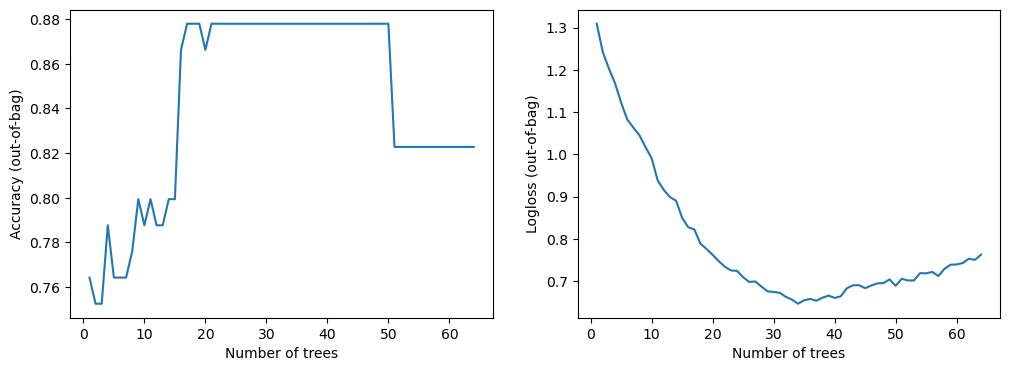


Train: 0.5554 Validation: 0.2912

Train mean: 0.3693 std: 0.2642

Validation mean: 0.3611 std: 0.2314


In [41]:
# GradientBoostedTreesModel

if not SUBMITION:

    features_slice = [i for i in features if len(i) > 2]

    submition_gbt_1, model_gbt_1,metrics_gbt_1 = train_model(
        train=train_out,test=test_out, features=features_slice,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.GradientBoostedTreesModel,            
        model_kwargs=dict(max_depth=5, num_trees=1000),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpnvwmdq2x as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:13.5951 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:13.5953 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:13.5953 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.186371. Found 555 examples.
Training model...
Model trained in 0:00:01.001839
Compiling model...


[INFO 23-07-21 05:12:15.7813 UTC kernel.cc:1242] Loading model from path /tmp/tmpnvwmdq2x/model/ with prefix 31553a97ea47436c
[INFO 23-07-21 05:12:15.7919 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 05:12:15.7919 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.1640


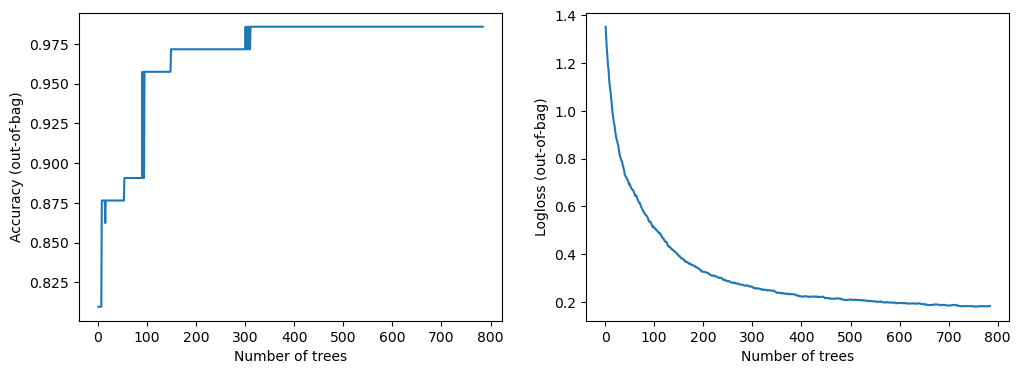


Train: 0.1127 Validation: 0.1640
##### Fold 2
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp8013y5vu as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:19.4965 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:19.4965 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:19.4965 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.173189. Found 555 examples.
Training model...
Model trained in 0:00:00.588179
Compiling model...


[INFO 23-07-21 05:12:21.2604 UTC kernel.cc:1242] Loading model from path /tmp/tmp8013y5vu/model/ with prefix 408ee78507f74dda
[INFO 23-07-21 05:12:21.2666 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.1576


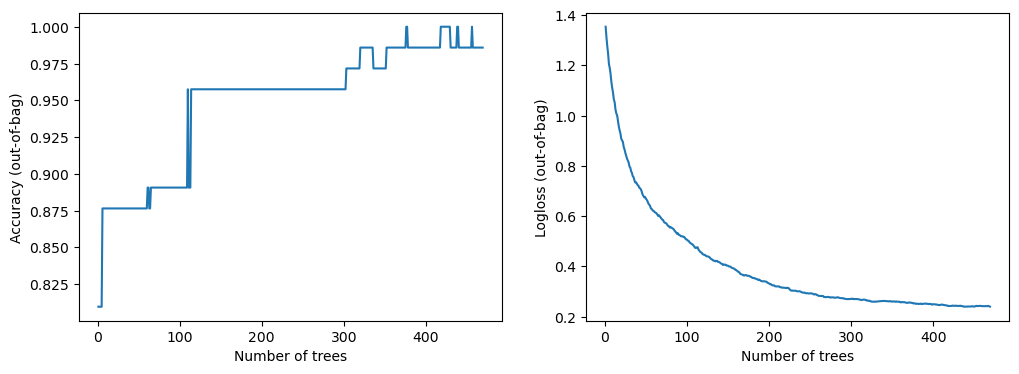


Train: 0.3058 Validation: 0.1576
##### Fold 3
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp8s3bkhxr as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:24.0548 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:24.0549 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:24.0549 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.176133. Found 555 examples.
Training model...
Model trained in 0:00:00.690730
Compiling model...


[INFO 23-07-21 05:12:25.9222 UTC kernel.cc:1242] Loading model from path /tmp/tmp8s3bkhxr/model/ with prefix 9dd4aea96fe04f6e
[INFO 23-07-21 05:12:25.9296 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 05:12:25.9297 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3384


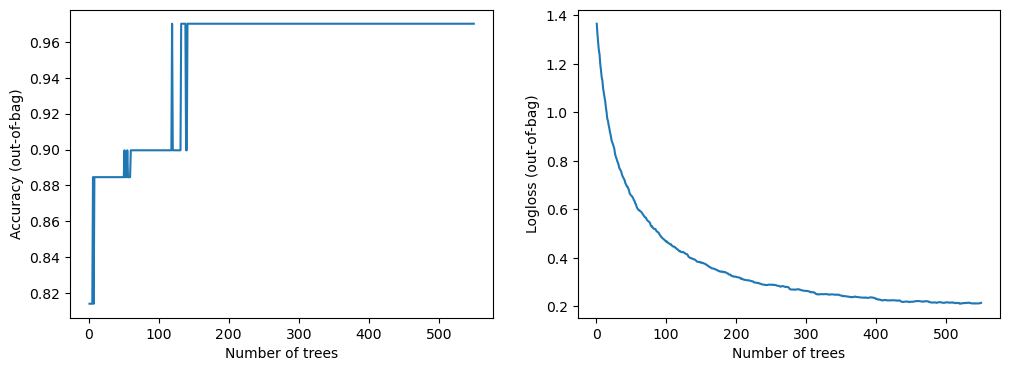


Train: 0.2765 Validation: 0.3384
##### Fold 4
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmph973t09z as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:28.6557 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:28.6557 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:28.6557 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.168419. Found 555 examples.
Training model...
Model trained in 0:00:00.603548
Compiling model...


[INFO 23-07-21 05:12:30.4300 UTC kernel.cc:1242] Loading model from path /tmp/tmph973t09z/model/ with prefix d3b8f86b8d194c08
[INFO 23-07-21 05:12:30.4362 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.2671


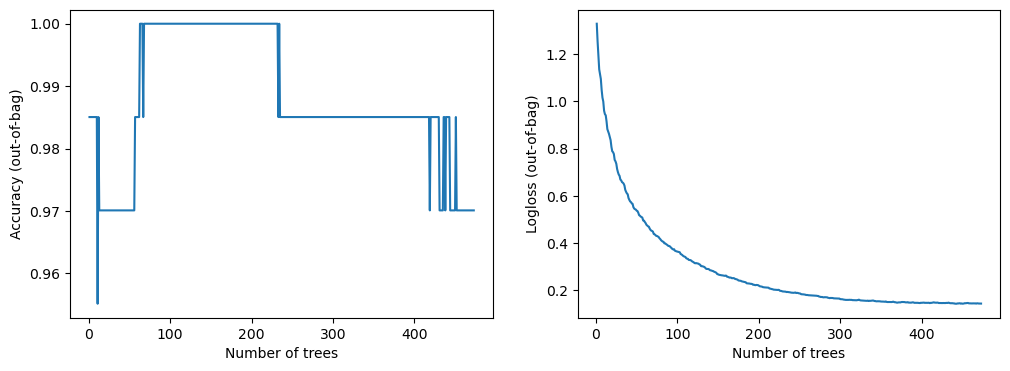


Train: 0.4713 Validation: 0.2671
##### Fold 5
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpdyhmmjp0 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:33.1933 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:33.1934 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:33.1934 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.184988. Found 555 examples.
Training model...
Model trained in 0:00:00.936464
Compiling model...


[INFO 23-07-21 05:12:35.3138 UTC kernel.cc:1242] Loading model from path /tmp/tmpdyhmmjp0/model/ with prefix 51eea418dd204a21
[INFO 23-07-21 05:12:35.3233 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2613


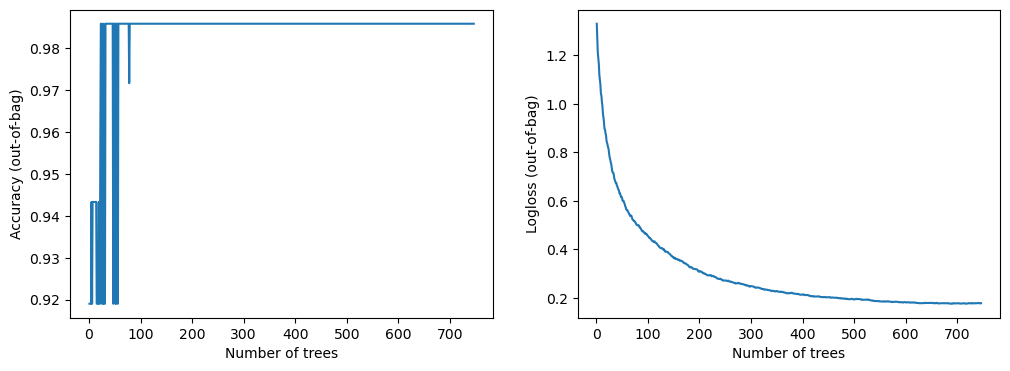


Train: 0.3730 Validation: 0.2613
##### Fold 6
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp4vxadma3 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:38.0790 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:38.0790 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:38.0790 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.170928. Found 555 examples.
Training model...
Model trained in 0:00:01.069737
Compiling model...


[INFO 23-07-21 05:12:40.3162 UTC kernel.cc:1242] Loading model from path /tmp/tmp4vxadma3/model/ with prefix 4004ed925e024859
[INFO 23-07-21 05:12:40.3272 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 05:12:40.3273 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2744


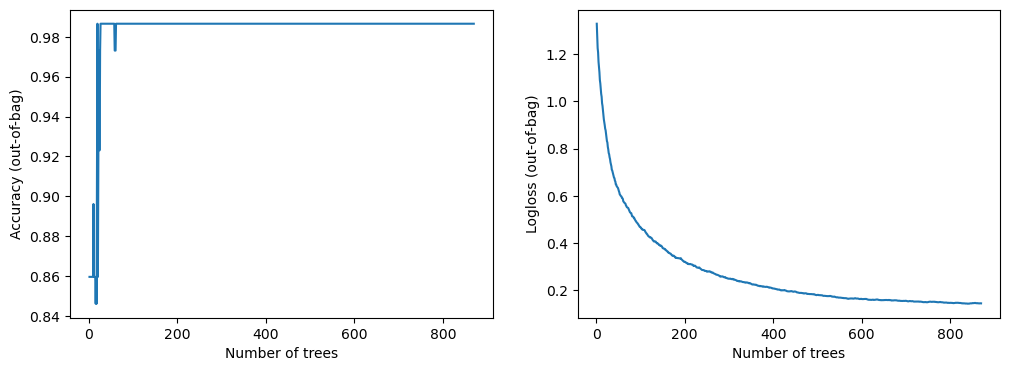


Train: 0.3571 Validation: 0.2744
##### Fold 7
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmp6sk0bhc3 as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:44.0395 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:44.0396 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:44.0397 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.198447. Found 555 examples.
Training model...
Model trained in 0:00:00.517140
Compiling model...


[INFO 23-07-21 05:12:45.7576 UTC kernel.cc:1242] Loading model from path /tmp/tmp6sk0bhc3/model/ with prefix 0161569adc2f421c
[INFO 23-07-21 05:12:45.7635 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 256ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.2420


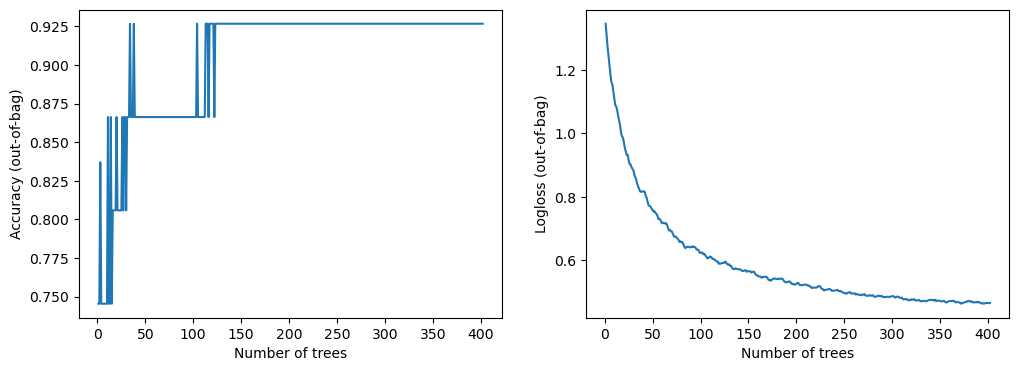


Train: 0.4262 Validation: 0.2420
##### Fold 8
Sum of 1"s : 97
Sum of 1"s : 11
Use /tmp/tmpeg8nuvdp as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:48.5214 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:48.5214 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:48.5215 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.164069. Found 556 examples.
Training model...
Model trained in 0:00:00.519739
Compiling model...


[INFO 23-07-21 05:12:50.2085 UTC kernel.cc:1242] Loading model from path /tmp/tmpeg8nuvdp/model/ with prefix 449b422ddc7d4602
[INFO 23-07-21 05:12:50.2139 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.2632


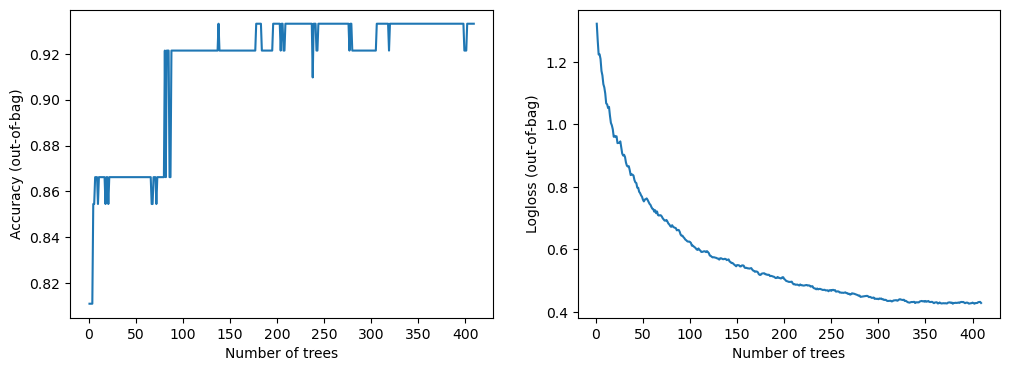


Train: 0.3848 Validation: 0.2632
##### Fold 9
Sum of 1"s : 98
Sum of 1"s : 10
Use /tmp/tmp9966nf3o as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:52.9873 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:52.9873 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:52.9873 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.174791. Found 556 examples.
Training model...
Model trained in 0:00:00.701218
Compiling model...


[INFO 23-07-21 05:12:54.8636 UTC kernel.cc:1242] Loading model from path /tmp/tmp9966nf3o/model/ with prefix 00e08ce2a2374a50
[INFO 23-07-21 05:12:54.8709 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-21 05:12:54.8710 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8852 - balanced_log_loss: 0.3122


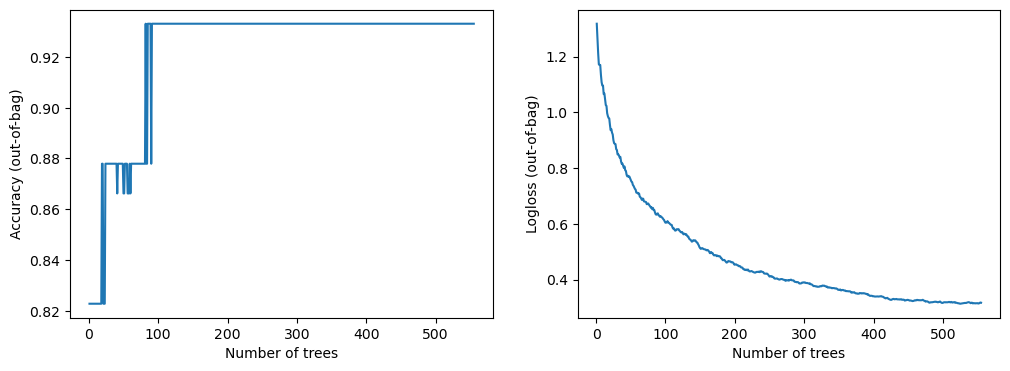


Train: 0.3803 Validation: 0.3122
##### Fold 10
Sum of 1"s : 98
Sum of 1"s : 10
Use /tmp/tmp13_63r2q as temporary training directory
Reading training dataset...


[WARNING 23-07-21 05:12:57.6228 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:57.6229 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-21 05:12:57.6229 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.163662. Found 556 examples.
Training model...
Model trained in 0:00:00.563099
Compiling model...


[INFO 23-07-21 05:12:59.3520 UTC kernel.cc:1242] Loading model from path /tmp/tmp13_63r2q/model/ with prefix 79e9dc3369274a0e
[INFO 23-07-21 05:12:59.3579 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.1399


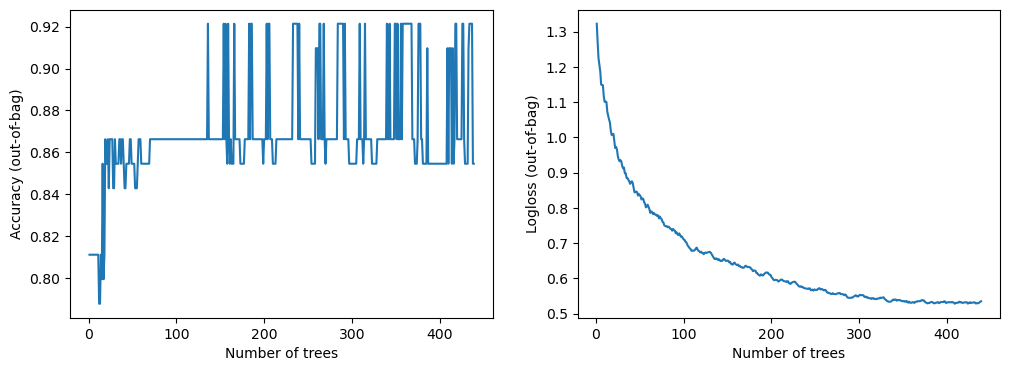


Train: 0.4631 Validation: 0.1399

Train mean: 0.3551 std: 0.1051

Validation mean: 0.2420 std: 0.0670


In [43]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

submition_gbt_2, model_gbt_2,metrics_gbt_2 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

# TabPFN

In [15]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    # y_true is prob that y is equals to 1, we assume that final probs would be P(class_1) = 1 - P(class_0)
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

In [16]:
def train_model_tabpfn_one(train: pd.DataFrame, submition: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    submition_df = pd.DataFrame(data=np.zeros((len(submition.index),1)),index=submition.index)
    train_df_out = pd.DataFrame(data=np.zeros((len(train.index),1)),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_sub = model.predict_proba(submition[features])[:,1]

    # Predict value for validation/Submition data
    submition_df[0] = p_sub.flatten() 
    train_df_out[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
            
    # metrics['accuracy'] = accuracy_score(train_df[label].values, p_train)
    train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    metrics['balanced_logloss'] = train_metric
    print(f"\nTrain: {train_metric:.4f}")
    
            
    return train_df_out,submition_df,model,metrics

In [17]:

def train_model_tabpfn_cv(train: pd.DataFrame, submition: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6) -> (pd.DataFrame, dict,  dict):

    # Create a dataframe of required size with zero values.
    # out_of_fold = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition_out = pd.DataFrame(data=np.zeros((len(submition.index),n_splits)),index=submition.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # Define & Train the model
            model = TabPFNClassifier(N_ensemble_configurations=64)
            model.fit(train_df[features],train_df[label])

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in out_of_fold dataframe
            p_train = model.predict_proba(train_df[features])[:,1]
            p_val = model.predict_proba(valid_df[features])[:,1]
            p_sub = model.predict_proba(submition[features])[:,1]
            
            # out_of_fold.loc[valid_ids, 0] = p_val
            submition_out[i] = p_sub

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[label].values,y_pred=p_val)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
            
    return submition,models,metrics

In [18]:
# TabPFN tabpfn_

if not SUBMITION:
    features_slice = [i for i in features if len(i) > 2]
    train_tabpfn_1, submition_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
        train=train_out,submition=test_out, features=features_slice)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515


In [21]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
submition_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,submition=test_out, features=features_slice, n_splits=6)

##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0559 Validation: 0.1706
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0553 Validation: 0.2929
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0538 Validation: 0.2968
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0448 Validation: 0.1985
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0518 Validation: 0.4682
##### Fold 6
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.1178

Train mean: 0.0521 std: 0.0040

Validation mean: 0.2575 std: 0.1247


# Ensemble Results

# Submission

In [24]:
# Aggragate Subs

RF_m = pd.Series(metrics_rf_3['val']).mean()
GBT_m = pd.Series(metrics_gbt_2['val']).mean()
TabPFN_m = pd.Series(metrics_tabpfn_2['val']).mean()

print('RF: metric ', RF_m)
print('GBT: metric ', GBT_m)
print('TabPFN: metric ', TabPFN_m)

Total_m = GBT_m + RF_m + TabPFN_m

RF_w = 2/10
GBT_w = 4.5/10
TabPFN_w = 3.5/10

print('RF weight: ', RF_w)
print('GBT weight: ', GBT_w)
print('TabPFN weight: ', TabPFN_w)

RF: metric  0.2840496152639389
GBT: metric  0.24200911670923234
TabPFN: metric  0.25747591040263845
RF weight:  0.2
GBT weight:  0.45
TabPFN weight:  0.35


In [28]:
submition_total = pd.concat([submition_rf_3.mean(axis=1).to_frame(),
                             submition_gbt_2.mean(axis=1).to_frame(),
                             submition_tabpfn_2.mean(axis=1).to_frame()]
                            ,axis=1)
submition_total.columns = ['RF','GBT','TabPFN']

submition_total['Ensemble'] = RF_w*submition_total['RF'] + GBT_w*submition_total['GBT'] + TabPFN_w*submition_total['TabPFN']

/tmp/ipykernel_32/2775741711.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  submition_tabpfn_2.mean(axis=1).to_frame()]


In [29]:
# submition_total
submition_total = submition_total[['Ensemble']].copy()
submition_total.columns = ['class_1']
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']]
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [30]:
submition_total

,class_0,class_1
Id,,
00eed32682bb,0.811332,0.188668
010ebe33f668,0.811332,0.188668
02fa521e1838,0.811332,0.188668
040e15f562a2,0.811332,0.188668
046e85c7cc7f,0.811332,0.188668


In [31]:
submition_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 00eed32682bb to 046e85c7cc7f
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   class_0  5 non-null      float64
 1   class_1  5 non-null      float64
dtypes: float64(2)
memory usage: 120.0+ bytes
